<a href="https://colab.research.google.com/github/DrSnach/GLUE-Benchmark/blob/master/2_SST2_with_GLove%26UME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

from time import time
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Lambda
import keras.backend as K
from keras.optimizers import Adadelta
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


GPU is available


In [3]:
# if `batch_size=-1`, will return the full dataset as `tf.tensor`s. ABSOLUTELY FUNDAMENTAL!

train_data, validation_data = tfds.load(name='glue/sst2', split=['train', 'validation'], batch_size=-1)

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteQSQLBB/glue-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteQSQLBB/glue-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/glue/sst2/1.0.0.incompleteQSQLBB/glue-test.tfrecord


Dataset glue downloaded and prepared to /root/tensorflow_datasets/glue/sst2/1.0.0. Subsequent calls will reuse this data.


In [4]:
train_data.keys()

dict_keys(['idx', 'label', 'sentence'])

In [5]:
df_train = pd.DataFrame(data=train_data)
df_val = pd.DataFrame(data=validation_data)

In [6]:
df_train.loc[df_train['label']==0]

,idx,label,sentence
0,16399,0,b'for the uninitiated plays better on video wi...
1,1680,0,b'like a giant commercial for universal studio...
4,27051,0,"b', this cross-cultural soap opera is painfull..."
6,54784,0,b'only masochistic moviegoers need apply . '
10,1456,0,b'revelatory nor truly edgy -- merely crassly ...
...,...,...,...
67342,32150,0,"b""too much ai n't - she-cute baggage into her ..."
67343,47134,0,"b'despite some charm and heart , this quirky s..."
67344,10487,0,b'even worse than its title '
67347,32842,0,b'the very definition of what critics have com...


In [7]:
# Creates function to clean data

def process_data (data):
  punct = "/-?!.,#$%\()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
  def clean_the_text (text, punt):
    for p in punct:
      text = text.replace(p, ' ')
      text = text.replace("b'", ' ', 1)
      text = text.replace('b"', ' ', 1)
    return text
  
  data =  data.astype(str).apply(lambda x: clean_the_text(x, punct))
  return data  
 

In [8]:
# Transform data to string as it came as tensor object. Cleans data

sentence = process_data(df_train.sentence.apply(str))
label = df_train.label.apply(int)
print(len(sentence))
print(len(label))

67349
67349


In [ ]:
sentence

0        It is this hat that it is certain that he was...
1        Her efficient looking up of the answer please...
2                 Both the workers will wear carnations '
3        John enjoyed drawing trees for his syntax hom...
4        We consider Leslie rather foolish  and Lou a ...
                              ...                        
8546                  a pencil with that to write broke '
8547     It was in the park last night that the police...
8548           John looked up the inside of the chimney '
8549                         You said she liked yourself'
8550        What we're using is their teaching material  
Name: sentence, Length: 8551, dtype: object

In [10]:
# Transform data to string for validation as well

val_sentence = process_data(df_val.sentence.apply(str))
val_label = df_val.label
print(len(val_sentence))
print(len(val_label))

872
872


In [11]:
val_sentence

0       a valueless kiddie paean to pro basketball un...
1       featuring a dangerously seductive performance...
2       i am sorry that i was unable to get the full ...
3       the inspirational screenplay by mike rich cov...
4       from the opening scenes   it 's clear that al...
                             ...                        
867     on the heels of the ring comes a similarly mo...
868     a broad   melodramatic estrogen opera that 's...
869     good car chases   great fight scenes   and a ...
870                         a sometimes tedious film   '
871               has all the depth of a wading pool   '
Name: sentence, Length: 872, dtype: object

In [ ]:
val_label

0       1
1       0
2       0
3       1
4       0
       ..
1038    1
1039    1
1040    0
1041    1
1042    1
Name: label, Length: 1043, dtype: int64

In [12]:
# Check lenght of sentence

count = sentence.apply(lambda x: len(str(x).split()))
print('Mean: %f' % (count.mean()))
print('Median: %f' % (count.median()))
print('Max: %f' % (count.max()))

Mean: 9.722876
Median: 7.000000
Max: 49.000000


In [13]:
# Brings Tokenizer and sequences padder

Tokenizer = tf.keras.preprocessing.text.Tokenizer
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences

tokenizer = Tokenizer(num_words=20000)
max_len = 32

In [14]:
# Creates vocabulary with all unique tokens

tokenizer.fit_on_texts(list(sentence) + list(val_sentence))
vocab_size = len(tokenizer.word_index) + 1 # Because it counts from 0
print(vocab_size)

14651


In [15]:
# transforms sentences into integers and pads to maxlen

encoded_sentences = tokenizer.texts_to_sequences(sentence)
padded_sentences = pad_sequences(encoded_sentences, maxlen=max_len, padding='post')

# Check
print(sentence[0])
print(encoded_sentences[0])
print(padded_sentences[0])

 for the uninitiated plays better on video with the sound '
[16, 2, 11788, 551, 119, 23, 278, 13, 2, 1212, 1]
[   16     2 11788   551   119    23   278    13     2  1212     1     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [16]:
# Same for validation

val_encoded_sentences = tokenizer.texts_to_sequences(val_sentence)
val_padded_sentences = pad_sequences(val_encoded_sentences, maxlen=max_len, padding='post')

# Check
print(val_sentence[0])
print(val_encoded_sentences[0])
print(val_padded_sentences[0])

 a valueless kiddie paean to pro basketball underwritten by the nba   '
[3, 13869, 1430, 8345, 6, 4737, 4851, 13870, 25, 2, 7587, 1]
[    3 13869  1430  8345     6  4737  4851 13870    25     2  7587     1
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
# # download pretrained GloVe embeddings

# !wget http://nlp.stanford.edu/data/glove.6B.zip

# !unzip glove.6B.zip

In [17]:
# Mount them from drive for quicker performance

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [18]:
# lists files

!ls "/content/gdrive/My Drive/Glove/glove.6B.100d.txt"

'/content/gdrive/My Drive/Glove/glove.6B.100d.txt'


In [19]:
# Creates dictionary of word embeddings

glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join('/content/gdrive/My Drive/Glove/glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [20]:
# Start with the embedding. Randomly initializing the zeros

embedding_dimensions = 100

embedding_matrix = np.zeros((vocab_size, embedding_dimensions))

for word, i in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector  

In [21]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout1D
from keras import layers

In [22]:
embed = Embedding(vocab_size,embedding_dimensions,weights=[embedding_matrix],input_length=max_len, trainable=False)

n_hidden = 32


In [23]:
model = Sequential()
model.add(embed)
#model.add(SpatialDropout1D(rate=0.2))
#model.add(Activation('sigmoid'))
model.add(LSTM(n_hidden, dropout=0.2, activation='tanh', recurrent_dropout=0.2))
preds = model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 100)           1465100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,482,157
Trainable params: 17,057
Non-trainable params: 1,465,100
_________________________________________________________________


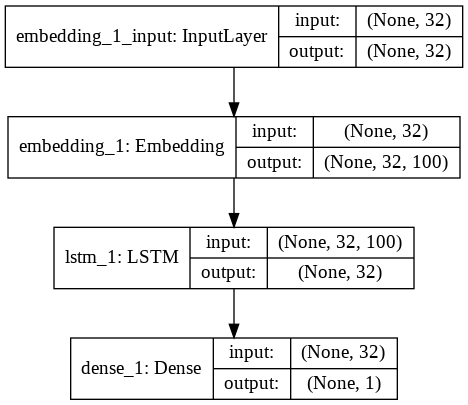

In [24]:
# Plot model graph
from keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [ ]:
# model = Sequential()
# model.add(embed)
# model.add(layers.Conv1D(64, 5, activation='relu')) 
# #model.add(LSTM(n_hidden))
# #model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(layers.GlobalMaxPooling1D())
# model.add(Dense(8, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.summary()

In [25]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.binary_crossentropy,
              metrics=['accuracy'])

In [26]:
# Early stopping to prevent under/over fitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')

In [ ]:
# Classs is imbalanced!! If not addressed the model finds a local minimum at 70
# by adscribing 1 to every example and thus acquiring 70% accuracy

#class_weights = {(0, 1):3, (1, 0):7}

# class_weights= {0:3, 1:7}

In [27]:
earlystop = EarlyStopping(monitor='accuracy', min_delta=0, patience=2, verbose=0, mode='auto')

history = model.fit(padded_sentences,
                    label,                    
                    epochs=8,
                    batch_size=32,
                    #class_weight=class_weights,                    
                    validation_split = 0.2,
                    verbose=True,                    

                    callbacks=[earlystop])

Train on 53879 samples, validate on 13470 samples
Epoch 1/8
53879/53879 [==============================] - 105s 2ms/step - loss: 0.5170 - accuracy: 0.7442 - val_loss: 0.4090 - val_accuracy: 0.8189
Epoch 2/8
53879/53879 [==============================] - 104s 2ms/step - loss: 0.4444 - accuracy: 0.7965 - val_loss: 0.3819 - val_accuracy: 0.8356
Epoch 3/8
53879/53879 [==============================] - 108s 2ms/step - loss: 0.4247 - accuracy: 0.8056 - val_loss: 0.3613 - val_accuracy: 0.8428
Epoch 4/8
53879/53879 [==============================] - 107s 2ms/step - loss: 0.4107 - accuracy: 0.8129 - val_loss: 0.3575 - val_accuracy: 0.8492
Epoch 5/8
53879/53879 [==============================] - 102s 2ms/step - loss: 0.3911 - accuracy: 0.8211 - val_loss: 0.3363 - val_accuracy: 0.8563
Epoch 6/8
53879/53879 [==============================] - 102s 2ms/step - loss: 0.3825 - accuracy: 0.8278 - val_loss: 0.3258 - val_accuracy: 0.8615
Epoch 7/8
53879/53879 [==============================] - 99s 2ms/ste

In [ ]:
# Uncomment and start again from Sequential to 
# Reset weights and retrain model

# K.clear_session()


In [34]:
# Test evaluation

print("Evaluate on test data")

results = model.evaluate(val_padded_sentences, val_label, batch_size=32)

print("test loss, test acc:", results)

Evaluate on test data
872/872 [==============================] - 0s 211us/step
test loss, test acc: [0.4256082138883958, 0.8027523159980774]


In [ ]:
prediction = model.predict(val_padded_sentences)
print(prediction)

In [ ]:
def binary_prediction (prediction):
  true_preds = []
  for pred in prediction:
    if pred <= 0.5:
      pred = 0
    if pred > 0.5:
      pred = 1
    true_preds.append(pred)
  return true_preds


In [ ]:
true_prediction = binary_prediction(prediction=prediction)
print(true_prediction)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [ ]:
## Checking that labels are comparable to do matthews correlation
## Matthews correlation yields a 0, which might be due to inconsistencies in the data

In [ ]:
val2 = val_label.to_list()

In [ ]:
val2

In [ ]:
true_prediction?

In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_corrcoef(val2, true_prediction)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


0.0

In [ ]:
val_label

0       1
1       0
2       0
3       1
4       0
       ..
1038    1
1039    1
1040    0
1041    1
1042    1
Name: label, Length: 1043, dtype: int64

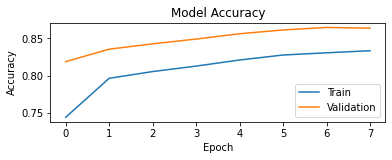

In [35]:
import seaborn as sns


# Plot Accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

In [ ]:
"""
Experiment with Universal Sentence Encoder yields same result. 
Solution is probably to use language model like BERT

"""

In [36]:
import tensorflow_hub as hub

In [37]:
embedding = "https://tfhub.dev/google/universal-sentence-encoder/4"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)


In [ ]:
hub_layer(sentence[:1])


In [38]:
model2 = tf.keras.Sequential()
model2.add(hub_layer)
model2.add(tf.keras.layers.Dense(16, activation='relu'))
model2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model2.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 512)               256797824 
_________________________________________________________________
dense (Dense)                (None, 16)                8208      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 256,806,049
Trainable params: 256,806,049
Non-trainable params: 0
_________________________________________________________________


In [39]:
model2.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [40]:
# Early stopping to prevent under/over fitting

from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='auto')

In [41]:
history = model2.fit(sentence,
                    label,                    
                    epochs=8,
                    batch_size=32,
                    #class_weight=class_weights,                    
                    validation_split = 0.2,
                    verbose=True,                    
                    callbacks=[earlystop])

Epoch 1/8
1684/1684 [==============================] - 132s 78ms/step - loss: 0.5453 - accuracy: 0.8645 - val_loss: 0.5303 - val_accuracy: 0.8817
Epoch 2/8
1684/1684 [==============================] - 131s 78ms/step - loss: 0.5105 - accuracy: 0.9362 - val_loss: 0.5236 - val_accuracy: 0.9062
Epoch 3/8
1684/1684 [==============================] - 130s 77ms/step - loss: 0.5050 - accuracy: 0.9476 - val_loss: 0.5224 - val_accuracy: 0.9099
Epoch 4/8
1684/1684 [==============================] - 131s 78ms/step - loss: 0.5022 - accuracy: 0.9540 - val_loss: 0.5218 - val_accuracy: 0.9118
Epoch 5/8
1684/1684 [==============================] - 131s 78ms/step - loss: 0.5005 - accuracy: 0.9579 - val_loss: 0.5208 - val_accuracy: 0.9163
Epoch 6/8
1684/1684 [==============================] - 131s 78ms/step - loss: 0.4996 - accuracy: 0.9599 - val_loss: 0.5214 - val_accuracy: 0.9126
Epoch 7/8
1684/1684 [==============================] - 132s 78ms/step - loss: 0.4988 - accuracy: 0.9613 - val_loss: 0.5222 -

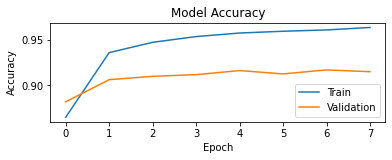

In [48]:
import seaborn as sns


# Plot Accuracy

plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'lower right')

In [ ]:
# Test evaluation

print("Evaluate on test data")

results2 = model2.evaluate(val_padded_sentences, val_label)

print("test loss, test acc:", results2)